##Распознавание лиц

In [3]:
%matplotlib inline
import numpy as np
from skimage import feature
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors

###Наивное распознавание лиц

In [4]:
#data loading
train_faces = np.loadtxt('data/train_faces.npy')
y_train = np.loadtxt('data/y_train.npy')
test_faces = np.loadtxt('data/test_faces.npy')
y_test = np.loadtxt('data/y_test.npy')

#nearest neighbors training
clf = NearestNeighbors(n_neighbors=1)
clf.fit(train_faces)

#face recongnition
naive_accuracy = 0.0
for face_desc, y_id in zip(test_faces, y_test):
    face_pred = clf.kneighbors(face_desc, return_distance=False)
    y_pred = y_train[face_pred[0][0]]
    if y_pred == y_id:
        naive_accuracy += 1
naive_accuracy /= len(test_faces)
print 'Accuracy : {0:0.3f}'.format(naive_accuracy)

Accuracy : 0.892


###Подход Eigenfaces

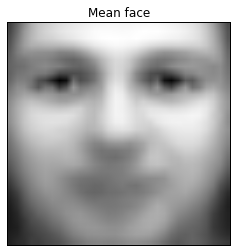

In [5]:
#PCA training
pca = PCA()
train_faces_pca = pca.fit_transform(train_faces)

#visualize a mean face
im = plt.imshow(np.reshape(pca.mean_, (32, 32)))
im.set_cmap('gray')
plt.title('Mean face')
plt.xticks([]),plt.yticks([])
plt.show()

image #178


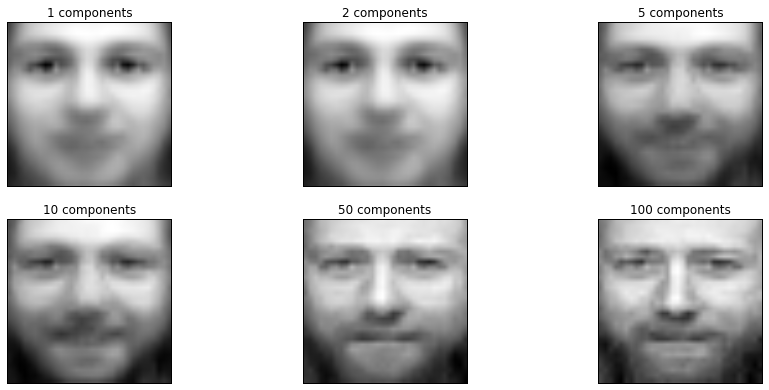

image #51


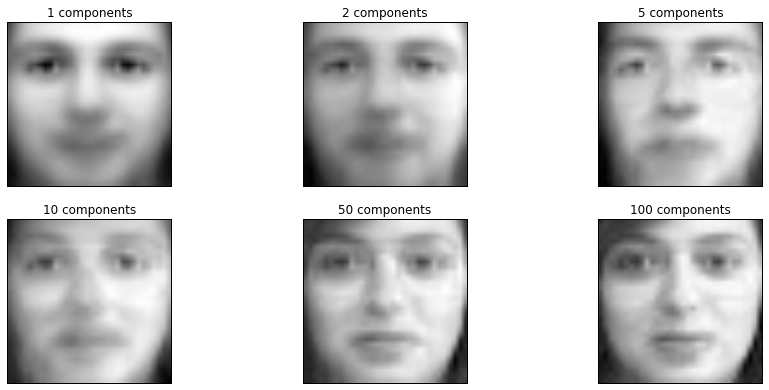

In [6]:
def restore_with_k_componentes(pca, k, X):
    return pca.mean_ + np.dot(X[:k], pca.components_[:k])

def visualize(pca, train_faces_pca, components_number, X_index):
    print 'image #{}'.format(X_index)
    fig = plt.figure(figsize=(15, 10)) 
    for i, number in enumerate(components_number):
        restored_image = restore_with_k_componentes(pca, number, train_faces_pca[X_index])
        plt.subplot2grid((3,3), (i//3, i%3))
        im = plt.imshow(np.reshape(restored_image, (32, 32)))
        im.set_cmap('gray')
        plt.title('{} components'.format(number))
        plt.xticks([]),plt.yticks([])
    plt.show()
    
visualize(pca, train_faces_pca, [1,2,5,10,50,100], 178)
visualize(pca, train_faces_pca, [1,2,5,10,50,100], 51)

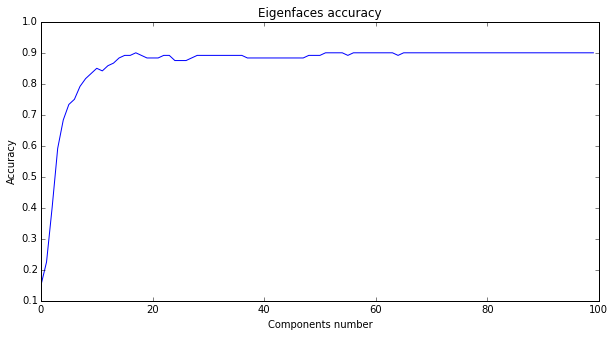

Max accuracy: 0.90
Number of principal components for getting naive accuracy: 16


In [29]:
def eigenfaces_recognition(K, train_faces_pca, test_faces_pca, y_train, y_test):

    train_faces_pca = [desc[:K] for desc in train_faces_pca]
    test_faces_pca = [desc[:K] for desc in test_faces_pca]
    
    #nearest neighbors training
    clf = NearestNeighbors(n_neighbors=1)
    clf.fit(train_faces_pca)
    
    #face recognition
    accuracy = 0.0
    for face_desc, y_id in zip(test_faces_pca, y_test):
        face_pred = clf.kneighbors(face_desc, return_distance=False)
        y_pred = y_train[face_pred[0][0]]
        if y_pred == y_id:
            accuracy += 1
    return accuracy

#calculating descriptors
pca = PCA()
train_faces_pca = pca.fit_transform(train_faces)
test_faces_pca = pca.transform(test_faces)

#calculating accuracy
scores = []
got_naive_accuracy = False
naive_accuracy_n_components = 0
for k in xrange(1, len(train_faces)):
    accuracy = eigenfaces_recognition(k, train_faces_pca, test_faces_pca, y_train, y_test)
    accuracy /= len(test_faces)
    if not got_naive_accuracy and accuracy >= naive_accuracy:
        got_naive_accuracy = True
        naive_accuracy_n_components = k
    scores.append(accuracy)
    
#visualizing scores
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)
plt.title('Eigenfaces accuracy')
ax.plot(scores[:100])
ax.set_xlabel('Components number')
ax.set_ylabel('Accuracy')
plt.show()

print 'Max accuracy: {0:0.2f}'.format(max(scores))
print 'Number of principal components for getting naive accuracy: {}'.format(naive_accuracy_n_components)

Для того, чтобы получить такое же качество, как в пункте 1 (accuracy = 0.892), достаточно 16 главных компонент.

Поиск с использованием только небольшого числа главных компонент может оказаться лучше поиска по несжатым дескрипторам, потому что главные компоненты описывают изменение конкретного фактора изображения (яркость лица или прически, растительность на лице, налицие очков и т.п.), то есть ключевые особенности изображения содержатся в главных компонентах, тогда как в случае несжатых дескрипторов они "размазаны" по всем элементам дескриптора.

###Гистограммы LBP признаков

In [27]:
def LBP_histogramms(data):
    histograms = []
    for image in data:
        f = feature.local_binary_pattern(image.reshape(32,32), 8, 4)
        n_bins = f.max() + 1
        hist, _ = np.histogram(f, normed=True, bins=n_bins, range=(0, n_bins))
        histograms.append(np.sqrt(hist))
    return histograms

#calculate descriptors
train_desc = LBP_histogramms(train_faces)
test_desc = LBP_histogramms(test_faces)

#nearest neighbors training
clf = NearestNeighbors(n_neighbors=1)
clf.fit(train_desc)

#face recongnition
LBP_accuracy = 0.0
for face_desc, y_id in zip(test_desc, y_test):
    face_pred = clf.kneighbors(face_desc, return_distance=False)
    y_pred = y_train[face_pred[0][0]]
    if y_pred == y_id:
        LBP_accuracy += 1
LBP_accuracy /= len(test_faces)
print 'Accuracy : {0:0.3f}'.format(LBP_accuracy)

Accuracy : 0.975


Данный метод позволяет добиться более высокого качества поиска (accuracy = 0.975), чем подход Eigenfaces (accuracy = 0.90).